In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

In [2]:
# SUBFUNCTIONS

def merge_capacity_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    capacities = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_capacities
        capacities = capacities.append(df,ignore_index=True)
    return capacities


def get_relative_capacities(results_dict):
    capacities = merge_capacity_data(results_dict)
    # get bas and delta dfs
    bas   = capacities.loc[capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    delta = capacities.loc[~capacities.scenario.isin(['BAS'])].reset_index(drop=True)
    # group
    bas   = bas.groupby(by=['scenario','technology','territory']).max().reset_index()
    delta = delta.groupby(by=['scenario','technology','territory']).max().reset_index()
    # map baseline capacities
    bas = bas.set_index('node')['value'].to_dict()
    delta['bas_cap'] = delta.node.map(bas)
    # compute delta
    delta['relative_change'] = delta['value'] - delta['bas_cap']
    return delta

## Run scenarios
Here we run the model across all five scenarios and append the results into a dictionary

In [3]:
#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# Params
timesteps=None
super_source=False
pprint=True
save_figures=True

infrasim_init_directories()

scenarios = {'BAS' : False,
             'BAU' : True,
             'NCO' : True,
             'EAG' : True,
             'COO' : True,
             'UTO' : True,}

results = {}
for s in scenarios:
        
    model_run = nextra(nodes,edges,flows,
                       scenario=s,
                       energy_objective=scenarios[s],
                       timesteps=timesteps,
                       #super_source=True,
                       #super_sink=True,
                       #res_factor=99,
                       #model_name='meow',
                      )

    model_run.build()
    model_run.run(pprint=False)
    model_results = model_run.get_results()
    # add scenarios to results
    if s == 'BAU' and scenarios[s] == False:
        s = 'BAS'
        
    model_results.results_capacities['scenario']       = s
    model_results.results_storages['scenario']         = s
    model_results.results_edge_flows['scenario']       = s
    model_results.results_capacity_change['scenario']  = s
    model_results.results_costs['scenario']            = s
    # append results
    results[s] = model_results
    
    print('> Completed: ' + s)
    
print('> Done.')   

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-03

> Completed: BAS

> Completed: BAU

> Completed: NCO

> Completed: EAG

> Completed: COO

> Completed: UTO
> Done.


## Create costs figure
This figure will show the required costs ($) in 2030 per scenario as a bar chart

In [18]:
def merge_cost_data(results_dict):
    '''Returns a dataframe with merged capacity data based on a dictionary containing a set of results class
    '''
    # init blank df
    costs = pd.DataFrame()
    # loop results 
    for k in results_dict.keys():
        df = results_dict[k].results_costs
        costs = costs.append(df,ignore_index=True)
    return costs

# run function
costs = merge_cost_data(results)
# convert to gw
#capacities['value'] = capacities['value'].apply(lambda row: mw_to_gw(row))
# pivot for bar chart
costs = costs.pivot_table(index=['scenario'],
                          columns=['technology'],
                          values='totex')
# sort by ascending
costs['total'] = costs.sum(axis=1)
costs = costs.sort_values("total").drop('total',axis=1)

# convert to million
costs = costs.mul(10**-9)

# plot
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
costs.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Cost to 2030 [$ billion]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)
f.savefig('../outputs/figures/totex_by_scenario.pdf',bbox_inches='tight')

KeyError: 'scenario'

In [5]:
costs = merge_cost_data(results)

costs



,node,capacity_change,technology,territory,capex,opex,totex,scenario
0,israel_wind,714.000000,Wind,Israel,5.292168e+09,1.685040e+07,5.309018e+09,BAS
1,israel_solar,0.000000,Solar,Israel,0.000000e+00,0.000000e+00,0.000000e+00,BAS
2,israel_natural_gas,1058.138664,Natural Gas,Israel,NaN,NaN,NaN,BAS
3,israel_diesel,0.000000,Diesel,Israel,0.000000e+00,0.000000e+00,0.000000e+00,BAS
4,israel_coal,0.000000,Coal,Israel,0.000000e+00,0.000000e+00,0.000000e+00,BAS
...,...,...,...,...,...,...,...,...
157,israel_gas_storage,0.000000,Gas Reservoir,Israel,NaN,NaN,NaN,UTO
158,israel_battery_storage,0.000000,Battery,Israel,0.000000e+00,0.000000e+00,0.000000e+00,UTO
159,jordan_battery_storage,5824.416125,Battery,Jordan,6.336965e+09,1.572592e+07,6.352691e+09,UTO
160,west_bank_battery_storage,0.000000,Battery,West Bank,0.000000e+00,0.000000e+00,0.000000e+00,UTO


## Create capacities figure
This figure will show the required capacity (GW) in 2030 per scenario as a bar chart

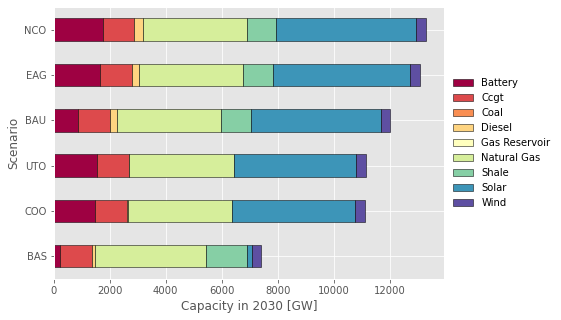

In [6]:
# run function
capacities = merge_capacity_data(results)
# convert to gw
#capacities['value'] = capacities['value'].apply(lambda row: mw_to_gw(row))
# pivot for bar chart
capacities = capacities.pivot_table(index=['scenario'],
                                    columns=['technology'],
                                    values='value')
# sort by ascending
capacities['total'] = capacities.sum(axis=1)
capacities = capacities.sort_values("total").drop('total',axis=1)

# plot
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
capacities.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Capacity in 2030 [GW]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)

## Relative capacity change
This figure shows the capacity change (GW) per scenario relative to BAS

Text(-0.03, 0.5, 'Relative Capacity Change (MW)')

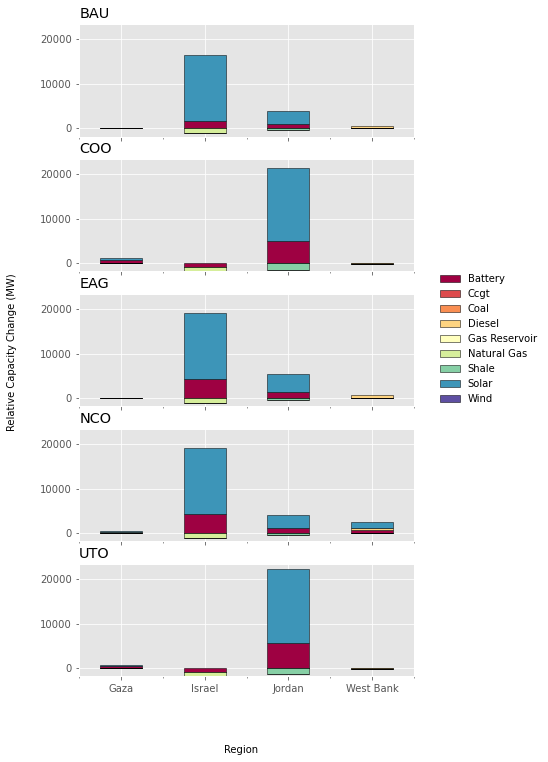

In [7]:
delta = get_relative_capacities(results)

f,ax = plt.subplots(ncols=1,nrows=5,figsize=(6,12),sharex=True,sharey=True)

count=0
for s in delta.scenario.unique():
    idx = delta.loc[delta.scenario.isin([s])]
    idx = idx.pivot_table(index=['territory'],columns=['technology'],values='relative_change')
    idx.plot.bar(stacked=True,rot=0,ax=ax[count],cmap='Spectral',edgecolor='black',legend=False)
    #ax[count].set_ylim([-5000,20000])
    ax[count].set_xlabel(None)
    ax[count].set_title(s,loc='left')
    count=count+1

plt.legend(loc='center left', bbox_to_anchor=(1.05, 3),frameon=False)

f.text(0.5, 0.04, 'Region', ha='center', va='center')
f.text(-0.03, 0.5, 'Relative Capacity Change (MW)', ha='center', va='center', rotation='vertical')



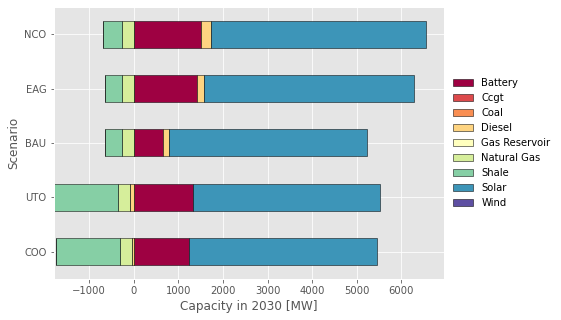

In [8]:
# plot
delta = get_relative_capacities(results)
plt.style.use('ggplot')
f,ax = plt.subplots(ncols=1,nrows=1,figsize=(7,5))
delta = delta.pivot_table(index=['scenario'],columns=['technology'],values='relative_change')
# sort by ascending
delta['total'] = delta.sum(axis=1)
delta = delta.sort_values("total").drop('total',axis=1)
delta.plot.barh(stacked=True,rot=0,ax=ax,cmap='Spectral',edgecolor='black')
ax.set_xlabel('Capacity in 2030 [MW]')
ax.set_ylabel('Scenario')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5),frameon=False)
#ax.set_xlim([-2000,7200])

## Visualise flows
This figure visualises flows between each territory

In [9]:
results['UTO'].plot_flows_sankey(height=500,title='No Cooperation')

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../')

from infrasim.optimise import *
from infrasim.utils import *

#File paths
nodes = '../data/nextra/spatial/network/nodes.shp'
edges = '../data/nextra/spatial/network/edges.shp'
flows = '../data/nextra/nodal_flows/processed_flows_2030.csv'

# Params
timesteps=None
super_source=False
pprint=True
save_figures=True

infrasim_init_directories()

scenarios = {'NCO' : True,}

results = {}
for s in scenarios:
        
    model_run = nextra(nodes,edges,flows,
                       scenario=s,
                       energy_objective=scenarios[s],
                       timesteps=timesteps,
                       #super_source=True,
                       #super_sink=True,
                       #res_factor=99,
                       #model_name='meow',
                      )

    model_run.build()
    model_run.run(pprint=False)
    model_results = model_run.get_results()
    # add scenarios to results
    if s == 'BAU' and scenarios[s] == False:
        s = 'BAS'
        
    model_results.results_capacities['scenario'] = s
    model_results.results_storages['scenario'] = s
    model_results.results_edge_flows['scenario'] = s
    # append results
    results[s] = model_results
    
    print('> Completed: ' + s)
    
print('> Done.')   


> Completed: NCO
> Done.


In [11]:
results['NCO'].plot_flows_sankey(height=500,title='No Cooperation')

In [12]:
results['NCO'].results_capacities.node.unique()

array(['israel_wind', 'israel_solar', 'israel_natural_gas',
       'israel_diesel', 'israel_coal', 'israel_ccgt', 'jordan_wind',
       'jordan_solar', 'jordan_natural_gas', 'jordan_diesel',
       'jordan_coal', 'jordan_ccgt', 'west_bank_solar', 'west_bank_wind',
       'west_bank_coal', 'west_bank_ccgt', 'west_bank_natural_gas',
       'west_bank_diesel', 'gaza_diesel', 'jordan_shale', 'gaza_solar',
       'gaza_natural_gas', 'israel_gas_storage', 'israel_battery_storage',
       'jordan_battery_storage', 'west_bank_battery_storage',
       'gaza_battery_storage'], dtype=object)

In [13]:
results['NCO'].results_capacity_change

,node,capacity_change,technology,territory
0,israel_wind,714.000000,Wind,Israel
1,israel_solar,13594.577504,Solar,Israel
2,israel_natural_gas,0.000000,Natural Gas,Israel
3,israel_diesel,-700.000000,Diesel,Israel
4,israel_coal,-4800.000000,Coal,Israel
5,israel_ccgt,3400.000000,Ccgt,Israel
6,jordan_wind,0.000000,Wind,Jordan
7,jordan_solar,2960.364859,Solar,Jordan
8,jordan_natural_gas,0.000000,Natural Gas,Jordan
9,jordan_diesel,0.000000,Diesel,Jordan


In [14]:
results['NCO'].results_costs

,node,capacity_change,technology,territory,capex,opex,totex
0,israel_wind,714.000000,Wind,Israel,5.292168e+09,1.685040e+07,5.309018e+09
1,israel_solar,13594.577504,Solar,Israel,4.807043e+10,1.209917e+08,4.819142e+10
2,israel_natural_gas,0.000000,Natural Gas,Israel,NaN,NaN,NaN
3,israel_diesel,0.000000,Diesel,Israel,0.000000e+00,0.000000e+00,0.000000e+00
4,israel_coal,0.000000,Coal,Israel,0.000000e+00,0.000000e+00,0.000000e+00
5,israel_ccgt,3400.000000,Ccgt,Israel,NaN,NaN,NaN
6,jordan_wind,0.000000,Wind,Jordan,0.000000e+00,0.000000e+00,0.000000e+00
7,jordan_solar,2960.364859,Solar,Jordan,1.046785e+10,2.634725e+07,1.049420e+10
8,jordan_natural_gas,0.000000,Natural Gas,Jordan,NaN,NaN,NaN
9,jordan_diesel,0.000000,Diesel,Jordan,0.000000e+00,0.000000e+00,0.000000e+00


<AxesSubplot:xlabel='territory', ylabel='totex'>

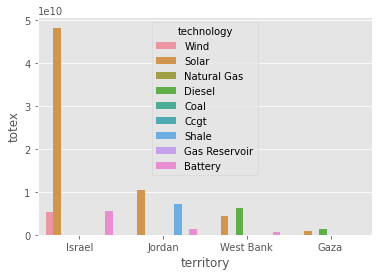

In [15]:
sns.barplot(x='territory',y='totex',hue='technology',data=results['NCO'].results_costs)

In [16]:
results['BAS'].plot_flows_heatmap(var='')

KeyError: 'BAS'

In [ ]:
results['BAS'].flows.node.unique()

In [ ]:
plt.style.use('ggplot')

demand = results['BAS'].flows.loc[results['BAS'].flows.node.str.contains('demand')]

f,ax=plt.subplots(nrows=1,ncols=1,figsize=(6,4),sharex=True)

ax.set_xscale("log")

sns.boxplot(x='value',y='node',palette='viridis',
            data=demand,ax=ax,width=0.3)

ax.set_ylabel(None)
ax.set_xlabel('Log(Energy Demand [kWh])')
ax.set_yticklabels(['Israel','Jordan','West Bank','Gaza'])
ax.grid(which='major',linestyle='-',color='white')
ax.grid(which='minor',linestyle='-',color='white',alpha=0.4)
plt.legend([],[], frameon=False)
ax.set_xlim([0,2*10**4])

ax.tick_params(axis="both",which='both',direction="in")
f.savefig('../outputs/figures/log_energy_demand.pdf',bbox_inches='tight')